In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Initialize an in-memory registry
ensemble_reports = {}

In [2]:
#Data Augmenation

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import random

# Paths for directories
aug_train_dir = '/kaggle/working/AugmentedTrain'
aug_test_dir = '/kaggle/working/AugmentedTest'

# Subfolders corresponding to the classes
subfolders = ['BG', 'N', 'D', 'P', 'V', 'S']

# Original dataset size
train_counts = {'BG': 75, 'D': 139, 'N': 75, 'P': 100, 'S': 122, 'V': 185}
test_counts = {'BG': 25, 'D': 46, 'N': 25, 'P': 34, 'S': 42, 'V': 62}

# Target counts for augmentation
train_target_count = 1500  # Target count for training set
test_target_count = 500    # Target count for test set

# Function to create augmentation folders
def create_aug_folders(base_dir):
    for subfolder in subfolders:
        aug_folder_path = os.path.join(base_dir, subfolder)
        os.makedirs(aug_folder_path, exist_ok=True)

# Create folders for augmented images
create_aug_folders(aug_train_dir)
create_aug_folders(aug_test_dir)

datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

def augment_image(image):
    augmented_images = []
    # Horizontal and Vertical Flips
    augmented_images.append(ImageOps.mirror(image))  # Horizontal flip
    augmented_images.append(ImageOps.flip(image))  # Vertical flip
    # Vertical-Horizontal Flip
    augmented_images.append(ImageOps.mirror(ImageOps.flip(image)))
    # Gaussian Blur
    augmented_images.append(image.filter(ImageFilter.GaussianBlur(radius=2)))
    # Gaussian Noise
    noise = np.random.normal(0, 25, (image.size[1], image.size[0], 3)).astype(np.uint8)
    noisy_image = np.array(image) + noise
    augmented_images.append(Image.fromarray(np.clip(noisy_image, 0, 255).astype(np.uint8)))
    # Gamma Correction
    gamma_corrected = ImageEnhance.Brightness(image).enhance(1.5)
    augmented_images.append(gamma_corrected)
    # Equalize Histogram
    equalized_image = ImageOps.equalize(image)
    augmented_images.append(equalized_image)
    # Increase Saturation, Hue, Red, Green, Blue
    augmented_images.append(ImageEnhance.Color(image).enhance(1.5))  # Saturation
    # Adjust RGB channels
    for i, factor in enumerate([1.2, 1.1, 1.3]):
        channels = list(image.split())
        channels[i] = ImageEnhance.Brightness(channels[i]).enhance(factor)
        augmented_images.append(Image.merge(image.mode, channels))
    return augmented_images

# Function to apply augmentations and save
def apply_augmentations(image_path, save_dir, num_augmentations):
    # Load image
    img = load_img(image_path)
    img_array = img_to_array(img)
    generated_count = 0

    # Generate augmented images with ImageDataGenerator
    img_batch = np.expand_dims(img_array, axis=0)
    for batch in datagen.flow(img_batch, batch_size=1):
        aug_img = batch[0].astype(np.uint8)
        aug_img = Image.fromarray(aug_img)
        aug_img.save(os.path.join(save_dir, f"aug_{generated_count}_{os.path.basename(image_path)}"))
        generated_count += 1
        if generated_count >= num_augmentations:
            break

    if generated_count < num_augmentations:
        # Apply custom augmentations
        custom_augmented_images = augment_image(img)
        for aug_img in custom_augmented_images:
            if generated_count >= num_augmentations:
                break
            aug_img.save(os.path.join(save_dir, f"custom_aug_{generated_count}_{os.path.basename(image_path)}"))
            generated_count += 1

# Function to augment dataset
def augment_dataset(original_dir, aug_dir, counts, target_count):
    for subfolder in subfolders:
        folder_path = os.path.join(original_dir, subfolder)
        save_path = os.path.join(aug_dir, subfolder)
        os.makedirs(save_path, exist_ok=True)

        current_count = counts[subfolder]
        num_to_generate = target_count - current_count

        if num_to_generate <= 0:
            continue

        images = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg', 'png'))]
        random.shuffle(images)

        for img_file in images:
            img_path = os.path.join(folder_path, img_file)
            apply_augmentations(img_path, save_path, num_to_generate // len(images))
            print(f"Augmented {img_file} from {subfolder} and saved to {save_path}")

        # Fill remaining images if needed
        remaining = target_count - len(os.listdir(save_path))
        while remaining > 0:
            for img_file in images:
                if remaining <= 0:
                    break
                img_path = os.path.join(folder_path, img_file)
                apply_augmentations(img_path, save_path, 1)
                remaining -= 1

# Augment train and test data
augment_dataset(
    '/kaggle/input/azh-data/colab/Train/Train',
    aug_train_dir,
    train_counts,
    train_target_count
)

augment_dataset(
    '/kaggle/input/azh-data/colab/Test/Test',
    aug_test_dir,
    test_counts,
    test_target_count
)


Augmented 14.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 56.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 40.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 27.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 73.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 21.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 47.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 16.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 5.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 43.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 61.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 19.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 65.jpg from BG and saved to /kaggle/working/AugmentedTrain/BG
Augmented 59.jpg from BG and saved to /kaggle/working/AugmentedTr

In [12]:
#Weighted Fusion
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'), 
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

weights = [0.25, 0.25, 0.5]  # Adjust based on performance

# Test data directory
test_dir = '/kaggle/working/AugmentedTest'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,  # Lower batch size if memory is a concern
    class_mode='categorical',
    shuffle=False  # IMPORTANT! So predictions align with test_generator.labels
)

# Predict with all models in batches
def predict_with_weighted_fusion_batch(test_generator):
    # Store predictions from all models
    model_preds = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        model_preds.append(preds)

    # Stack predictions: shape -> (n_models, n_samples, n_classes)
    model_preds = np.stack(model_preds, axis=0)

    # Weighted average fusion
    weighted_proba = np.average(model_preds, axis=0, weights=weights)

    # Final predictions (argmax over classes)
    final_predictions = np.argmax(weighted_proba, axis=1)
    return final_predictions, model_preds



final_preds, model_preds = predict_with_weighted_fusion_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Weighted Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 206ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
Accuracy (Weighted Fusion - BATCHED): 0.8241
Classification Report:
               precision    recall  f1-score   support

          BG       0.99      1.00      0.99       475
           D       0.90      0.74      0.81       414
           N       0.93      1.00      0.96       475
           P       0.63      0.55      0.59       442
           S       0.80      0.72      0.76       420
           V       0.69      0.89      0.78       434

    accuracy                           0.82      2660
   macro avg       0.82      0.82      0.82      2660
weighted avg       0.83      0.82      0.82      2660



In [16]:
#max likelihood
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras')
]

# Test data directory
test_dir = '/kaggle/working/AugmentedTest'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,  # Lower if you still face memory issues
    class_mode='categorical',
    shuffle=False  # So predictions align with test_generator.labels
)

# Predict with all models in batches using Maximum Likelihood Fusion
def predict_with_max_likelihood_fusion_batch(test_generator):
    # Store predictions from all models
    model_preds = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        model_preds.append(preds)

    # Stack predictions: shape -> (n_models, n_samples, n_classes)
    model_preds = np.stack(model_preds, axis=0)

    # Maximum Likelihood Fusion: Take maximum confidence across models for each class
    max_likelihood_proba = np.max(model_preds, axis=0)

    # Final predictions (argmax over classes)
    final_predictions = np.argmax(max_likelihood_proba, axis=1)
    return final_predictions, model_preds


# Perform Maximum Likelihood Fusion
final_preds, model_preds = predict_with_max_likelihood_fusion_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Max Likelihood Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 216ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step
Accuracy (Max Likelihood Fusion - BATCHED): 0.8038
Classification Report:
               precision    recall  f1-score   support

          BG       0.98      1.00      0.99       475
           D       0.82      0.76      0.79       414
           N       0.92      1.00      0.95       475
           P       0.63      0.45      0.53       442
           S       0.72      0.71      0.72       420
           V       0.69      0.86      0.77       434

    accuracy                           0.80      2660
   macro avg       0.79      0.80      0.79      2660
weighted avg       0.80      0.80      0.80      2660



In [21]:
#Hard voting
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory
test_dir = '/kaggle/working/AugmentedTest'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict with Hard Voting Fusion
def predict_with_hard_voting_batch(test_generator):
    # Store raw class predictions and simulated softmax outputs
    raw_preds = []
    softmax_preds = []

    for model in models:
        probs = model.predict(test_generator, verbose=1)
        softmax_preds.append(probs)
        raw_preds.append(np.argmax(probs, axis=1))

    # Convert to numpy arrays
    raw_preds = np.stack(raw_preds, axis=0)          # Shape: (n_models, n_samples)
    softmax_preds = np.stack(softmax_preds, axis=0)  # Shape: (n_models, n_samples, n_classes)

    # Hard voting
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=raw_preds)

    return final_predictions, softmax_preds



# Perform Hard Voting Fusion
final_preds, model_preds = predict_with_hard_voting_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Hard Voting Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step
Accuracy (Hard Voting Fusion - BATCHED): 0.7951
Classification Report:
               precision    recall  f1-score   support

          BG       0.96      1.00      0.98       475
           D       0.74      0.77      0.76       414
           N       0.88      1.00      0.94       475
           P       0.63      0.47      0.54       442
           S       0.79      0.63      0.70       420
           V       0.70      0.86      0.77       434

    accuracy                           0.80      2660
   macro avg       0.78      0.79      0.78      2660
weighted avg       0.79      0.80      0.79      2660



In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory and classes
test_dir = '/kaggle/working/AugmentedTest'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

y_true = test_generator.classes

# Step 1: Get stacked predictions from base models
def get_model_predictions(test_generator):
    base_model_predictions = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        base_model_predictions.append(preds)

    base_model_predictions = np.array(base_model_predictions)  # (n_models, n_samples, n_classes)
    model_preds = base_model_predictions.copy()  # Keep this for visualization

    # Reshape for meta-model input: (n_samples, n_models * n_classes)
    stacked_input = np.moveaxis(base_model_predictions, 0, 1).reshape(len(y_true), -1)
    return stacked_input, model_preds

# Step 2: Generate training data for XGBoost
X, model_preds = get_model_predictions(test_generator)
y = y_true

X_train, X_meta, y_train, y_meta = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Train XGBoost meta-model
meta_model = XGBClassifier(
    objective='multi:softprob',  # Needed for predict_proba
    num_class=len(class_names),
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    use_label_encoder=False,
    random_state=42
)

meta_model.fit(X_train, y_train)

# Step 4: Predict using meta-model
final_preds = meta_model.predict(X_meta)
proba_preds = meta_model.predict_proba(X_meta)

# Step 5: Evaluate
accuracy = accuracy_score(y_meta, final_preds)
report = classification_report(y_meta, final_preds, target_names=class_names)

print(f"Stacking Accuracy (XGBoost Meta-Model): {accuracy:.4f}")
print("Classification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 224ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step
Stacking Accuracy (XGBoost Meta-Model): 0.8910
Classification Report:
               precision    recall  f1-score   support

          BG       1.00      1.00      1.00       142
           D       0.90      0.81      0.85       124
           N       0.99      1.00      1.00       143
           P       0.75      0.78      0.77       133
           S       0.88      0.85      0.87       126
           V       0.81      0.88      0.85       130

    accuracy                           0.89       798
   macro avg       0.89      0.89      0.89       798
weighted avg       0.89      0.89      0.89       798



In [8]:
y_true = test_generator.classes

In [10]:
proba_preds = np.max(model_preds, axis=0)

In [ ]:
# proba_preds = np.average(model_preds, axis=0, weights=weights) #for hard voting

In [16]:
#Visualization

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score
)

# Ensure y_true, final_preds, model_preds, weights, and class_names are available
# model_preds must be the stacked raw probabilities from all models
# proba_preds is the weighted softmax probabilities (same as in fusion cell)

# Get weighted probabilities again (for ROC), in case proba_preds not available
# proba_preds = np.average(model_preds, axis=0, weights=weights)

# Evaluation Metrics
# accuracy = accuracy_score(y_true, final_preds)
# precision = precision_score(y_true, final_preds, average='macro')
# recall = recall_score(y_true, final_preds, average='macro')
# f1 = f1_score(y_true, final_preds, average='macro')

# print("Classification Report:\n", classification_report(y_true, final_preds, target_names=class_names))

# Visualize metrics
def visualize_metrics(metrics):
    names = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(8, 5))
    plt.bar(names, values, color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title("Performance Metrics")
    for i, val in enumerate(values):
        plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
    plt.ylabel("Score")
    plt.show()

# Confusion matrix
def visualize_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# ROC curve
def visualize_roc_curve(y_true, y_pred_prob, class_labels):
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
        auc = roc_auc_score(y_true == i, y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

# Run visualizations
# metrics_dict = {
#     'accuracy': accuracy,
#     'precision': precision,
#     'recall': recall,
#     'f1-score': f1
# }
# visualize_metrics(metrics_dict)
visualize_confusion_matrix(y_true, final_preds, class_names)
# visualize_roc_curve(y_true, proba_preds, class_names)


ValueError: Found input variables with inconsistent numbers of samples: [2660, 798]

In [3]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

weights = [0.25, 0.25, 0.5]  # Adjust based on performance

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,  # Lower batch size if memory is a concern
    class_mode='categorical',
    shuffle=False  # IMPORTANT! So predictions align with test_generator.labels
)

# Predict with all models in batches
def predict_with_weighted_fusion_batch(test_generator):
    # Store predictions from all models
    model_preds = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        model_preds.append(preds)

    # Stack predictions: shape -> (n_models, n_samples, n_classes)
    model_preds = np.stack(model_preds, axis=0)

    # Weighted average fusion
    weighted_proba = np.average(model_preds, axis=0, weights=weights)

    # Final predictions (argmax over classes)
    final_predictions = np.argmax(weighted_proba, axis=1)
    return final_predictions


# Perform Weighted Soft Voting Fusion
final_preds = predict_with_weighted_fusion_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Weighted Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)

from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    true_labels,
    final_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['Weighted Soft Voting'] = rpt


I0000 00:00:1745939029.101508      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745939043.884117      89 service.cc:148] XLA service 0x79d4c8002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745939043.884951      89 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745939044.389815      89 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/84 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step

I0000 00:00:1745939047.840975      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 37s 255ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step
Accuracy (Weighted Fusion - BATCHED): 0.8297
Classification Report:
               precision    recall  f1-score   support

          BG       0.99      1.00      0.99       475
           D       0.93      0.75      0.83       414
           N       0.93      0.99      0.96       475
           P       0.63      0.58      0.60       442
           S       0.81      0.75      0.78       420
           V       0.70      0.88      0.78       434

    accuracy                           0.83      2660
   macro avg       0.83      0.82      0.82      2660
weighted avg       0.83      0.83      0.83      2660



In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras')
]

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,  # Lower if you still face memory issues
    class_mode='categorical',
    shuffle=False  # So predictions align with test_generator.labels
)

# Predict with all models in batches using Maximum Likelihood Fusion
def predict_with_max_likelihood_fusion_batch(test_generator):
    # Store predictions from all models
    model_preds = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        model_preds.append(preds)

    # Stack predictions: shape -> (n_models, n_samples, n_classes)
    model_preds = np.stack(model_preds, axis=0)

    # Maximum Likelihood Fusion: Take maximum confidence across models for each class
    max_likelihood_proba = np.max(model_preds, axis=0)

    # Final predictions (argmax over classes)
    final_predictions = np.argmax(max_likelihood_proba, axis=1)
    return final_predictions


# Perform Maximum Likelihood Fusion
final_preds = predict_with_max_likelihood_fusion_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Max Likelihood Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)

from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    true_labels,
    final_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['MaxLikelihood'] = rpt



Found 2660 images belonging to 6 classes.
84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 242ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step
Accuracy (Max Likelihood Fusion - BATCHED): 0.8105
Classification Report:
               precision    recall  f1-score   support

          BG       0.98      1.00      0.99       475
           D       0.86      0.76      0.81       414
           N       0.91      0.99      0.95       475
           P       0.64      0.48      0.55       442
           S       0.72      0.72      0.72       420
           V       0.70      0.88      0.78       434

    accuracy                           0.81      2660
   macro avg       0.80      0.80      0.80      2660
weighted avg       0.81      0.81      0.80      2660



In [8]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load models
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict with Hard Voting Fusion
def predict_with_hard_voting_batch(test_generator):
    # Store predictions as class indices
    model_preds = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        class_preds = np.argmax(preds, axis=1)
        model_preds.append(class_preds)

    # Stack predictions: shape -> (n_models, n_samples)
    model_preds = np.stack(model_preds, axis=0)

    # Hard voting (majority vote for each sample)
    final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=model_preds)

    return final_predictions


# Perform Hard Voting Fusion
final_preds = predict_with_hard_voting_batch(test_generator)

# Evaluation
true_labels = test_generator.classes
accuracy = accuracy_score(true_labels, final_preds)
report = classification_report(true_labels, final_preds, target_names=class_names)

print(f"Accuracy (Hard Voting Fusion - BATCHED): {accuracy:.4f}")
print("Classification Report:\n", report)

from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    true_labels,
    final_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['Hard Voting'] = rpt


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Accuracy (Hard Voting Fusion - BATCHED): 0.8000
Classification Report:
               precision    recall  f1-score   support

          BG       0.96      1.00      0.98       475
           D       0.77      0.80      0.79       414
           N       0.88      0.99      0.93       475
           P       0.65      0.48      0.55       442
           S       0.78      0.64      0.70       420
           V       0.70      0.85      0.77       434

    accuracy                           0.80      2660
   macro avg       0.79      0.79      0.79      2660
weighted avg       0.79      0.80      0.79      2660



In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load pre-trained models (base models)
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

true_labels = test_generator.classes

# Collect predictions from all models
def get_model_predictions(test_generator):
    base_model_predictions = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        base_model_predictions.append(preds)

    # Convert to shape (n_samples, n_models * n_classes)
    base_model_predictions = np.array(base_model_predictions)  # (n_models, n_samples, n_classes)
    base_model_predictions = np.moveaxis(base_model_predictions, 0, 1)  # (n_samples, n_models, n_classes)
    base_model_predictions = base_model_predictions.reshape(base_model_predictions.shape[0], -1)
    return base_model_predictions

# Get base model predictions as features
X = get_model_predictions(test_generator)
y = true_labels

# Split data for meta-model training (stacking)
X_train, X_meta, y_train, y_meta = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Meta-model (XGBoost)
meta_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    eval_metric='mlogloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

# Train meta-model on base model outputs
meta_model.fit(X_train, y_train)

# Predict using meta-model
y_meta_preds = meta_model.predict(X_meta)

# Evaluate
accuracy = accuracy_score(y_meta, y_meta_preds)
report = classification_report(y_meta, y_meta_preds, target_names=class_names)

print(f"Stacking Accuracy (XGBoost Meta-Model): {accuracy:.4f}")
print("Classification Report:\n", report)

from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    y_meta,
    y_meta_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['XGBoost'] = rpt


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 242ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Stacking Accuracy (XGBoost Meta-Model): 0.8947
Classification Report:
               precision    recall  f1-score   support

          BG       0.99      1.00      1.00       142
           D       0.91      0.81      0.86       124
           N       0.99      1.00      1.00       143
           P       0.72      0.81      0.76       133
           S       0.95      0.84      0.89       126
           V       0.83      0.88      0.85       130

    accuracy                           0.89       798
   macro avg       0.90      0.89      0.89       798
weighted avg       0.90      0.89      0.90       798



In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load pre-trained models (base models)
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

true_labels = test_generator.classes

# Collect predictions from all models
def get_model_predictions(test_generator):
    base_model_predictions = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        base_model_predictions.append(preds)

    # Convert to shape (n_samples, n_models * n_classes)
    base_model_predictions = np.array(base_model_predictions)  # (n_models, n_samples, n_classes)
    base_model_predictions = np.moveaxis(base_model_predictions, 0, 1)  # (n_samples, n_models, n_classes)
    base_model_predictions = base_model_predictions.reshape(base_model_predictions.shape[0], -1)
    return base_model_predictions

# Get base model predictions as features
X = get_model_predictions(test_generator)
y = true_labels

# Split data for meta-model training (stacking)
X_train, X_meta, y_train, y_meta = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Meta-model (e.g., Logistic Regression)
meta_model = LogisticRegression(max_iter=1000, multi_class='multinomial')

# Train meta-model on base model outputs
meta_model.fit(X_train, y_train)

# Predict using meta-model
y_meta_preds = meta_model.predict(X_meta)

# Evaluate
accuracy = accuracy_score(y_meta, y_meta_preds)
report = classification_report(y_meta, y_meta_preds, target_names=class_names)

print(f"Stacking Accuracy (Logistic RegressionMeta-Model): {accuracy:.4f}")
print("Classification Report:\n", report)

from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    y_meta,
    y_meta_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['LogisticReg'] = rpt


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 243ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Stacking Accuracy (Logistic RegressionMeta-Model): 0.8471
Classification Report:
               precision    recall  f1-score   support

          BG       0.99      1.00      1.00       142
           D       0.87      0.80      0.83       124
           N       0.96      1.00      0.98       143
           P       0.62      0.64      0.63       133
           S       0.86      0.79      0.83       126
           V       0.78      0.82      0.80       130

    accuracy                           0.85       798
   macro avg       0.85      0.84      0.84       798
weighted avg       0.85      0.85      0.85       798



In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load pre-trained models (base models)
models = [
    load_model('/kaggle/input/models/best_mobilenet_model 73.keras'),
    load_model('/kaggle/input/models/best_model (nasnet).keras'),
    load_model('/kaggle/input/models/best_vgg19_model 80.keras'),
]

# Test data directory
test_dir = '/kaggle/input/azhdata2/colab (augmented)/Test/Test/Augmented'
class_names = ['BG', 'D', 'N', 'P', 'S', 'V']

# Data Generator for Test Set (batch processing)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

true_labels = test_generator.classes

# Collect predictions from all models
def get_model_predictions(test_generator):
    base_model_predictions = []
    for model in models:
        preds = model.predict(test_generator, verbose=1)
        base_model_predictions.append(preds)

    # Convert to shape (n_samples, n_models * n_classes)
    base_model_predictions = np.array(base_model_predictions)  # (n_models, n_samples, n_classes)
    base_model_predictions = np.moveaxis(base_model_predictions, 0, 1)  # (n_samples, n_models, n_classes)
    base_model_predictions = base_model_predictions.reshape(base_model_predictions.shape[0], -1)
    return base_model_predictions

# Get base model predictions as features
X = get_model_predictions(test_generator)
y = true_labels

# Split data for meta-model training (stacking)
X_train, X_meta, y_train, y_meta = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Meta-model (Random Forest)
meta_model = RandomForestClassifier(
    n_estimators=100,  # Number of decision trees
    max_depth=10,  # Limit tree depth to reduce overfitting
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Train meta-model on base model outputs
meta_model.fit(X_train, y_train)

# Predict using meta-model
y_meta_preds = meta_model.predict(X_meta)

# Evaluate
accuracy = accuracy_score(y_meta, y_meta_preds)
report = classification_report(y_meta, y_meta_preds, target_names=class_names)

print(f"Stacking Accuracy (Random Forest Meta-Model): {accuracy:.4f}")
print("Classification Report:\n",report)


from sklearn.metrics import classification_report

# … your fusion logic that produces `final_preds` and you already have `true_labels` & `class_names`
rpt = classification_report(
    y_meta,
    y_meta_preds,
    target_names=class_names,
    output_dict=True
)

# give each a unique name, e.g. 'Weighted', 'MaxLikelihood', 'HardVoting',...
ensemble_reports['Random Forest'] = rpt



/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2660 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 36s 259ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
Stacking Accuracy (Random Forest Meta-Model): 0.8872
Classification Report:
               precision    recall  f1-score   support

          BG       0.99      1.00      1.00       142
           D       0.95      0.81      0.87       124
           N       0.99      1.00      1.00       143
           P       0.69      0.78      0.73       133
           S       0.94      0.83      0.88       126
           V       0.80      0.88      0.84       130

    accuracy                           0.89       798
   macro avg       0.89      0.88      0.89       798
weighted avg       0.90      0.89      0.89       798



In [7]:
ensemble_reports

{'Weighted Soft Voting': {'BG': {'precision': 0.9895833333333334,
   'recall': 1.0,
   'f1-score': 0.9947643979057591,
   'support': 475},
  'D': {'precision': 0.9309309309309309,
   'recall': 0.748792270531401,
   'f1-score': 0.8299866131191433,
   'support': 414},
  'N': {'precision': 0.9289940828402367,
   'recall': 0.991578947368421,
   'f1-score': 0.9592668024439919,
   'support': 475},
  'P': {'precision': 0.6280788177339901,
   'recall': 0.5769230769230769,
   'f1-score': 0.6014150943396226,
   'support': 442},
  'S': {'precision': 0.8087855297157622,
   'recall': 0.7452380952380953,
   'f1-score': 0.7757125154894672,
   'support': 420},
  'V': {'precision': 0.70018281535649,
   'recall': 0.8824884792626728,
   'f1-score': 0.780835881753313,
   'support': 434},
  'accuracy': 0.8296992481203007,
  'macro avg': {'precision': 0.8310925849851238,
   'recall': 0.8241701448872778,
   'f1-score': 0.8236635508418829,
   'support': 2660},
  'weighted avg': {'precision': 0.833800669124666

,Accuracy,Macro F1,BG F1,D F1,N F1,P F1,S F1,V F1
Method,,,,,,,,
Weighted Soft Voting,0.829699,0.823664,0.994764,0.829987,0.959267,0.601415,0.775713,0.780836
MaxLikelihood,0.810526,0.799399,0.990615,0.807198,0.946519,0.549223,0.720764,0.782077
Hard Voting,0.800000,0.786901,0.980392,0.786730,0.931615,0.553966,0.702350,0.766355
XGBoost,0.894737,0.892889,0.996491,0.859574,0.996516,0.763251,0.890756,0.850746
LogisticReg,0.847118,0.843356,0.996491,0.831933,0.979452,0.627306,0.826446,0.798507
Random Forest,0.887218,0.885969,0.996491,0.873362,0.996516,0.732394,0.877637,0.839416


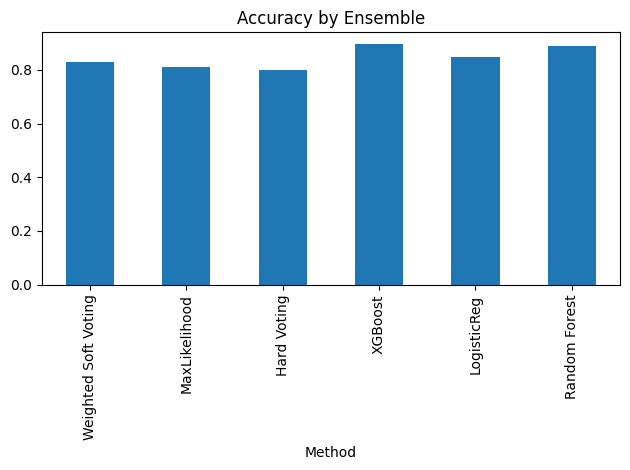

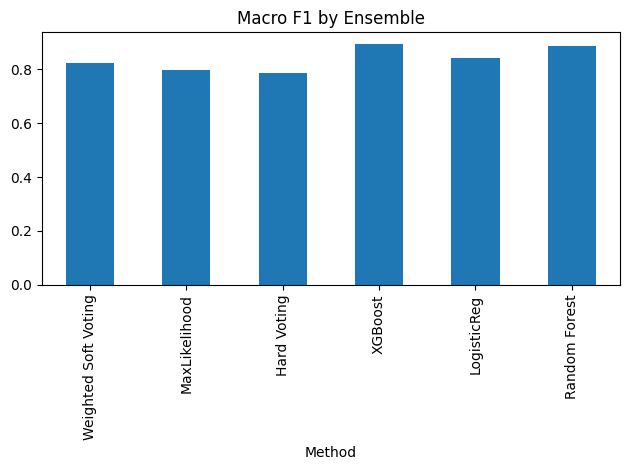

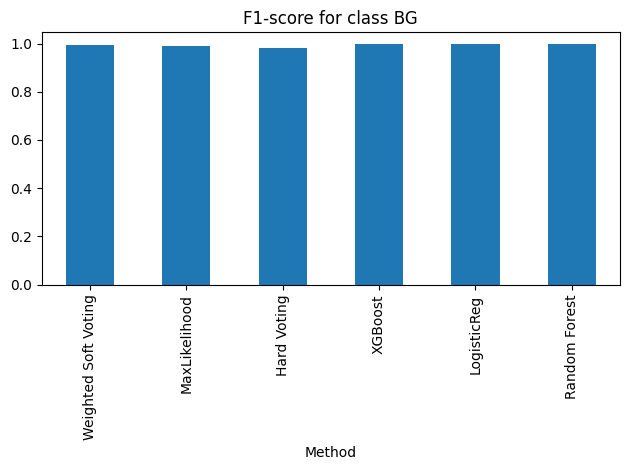

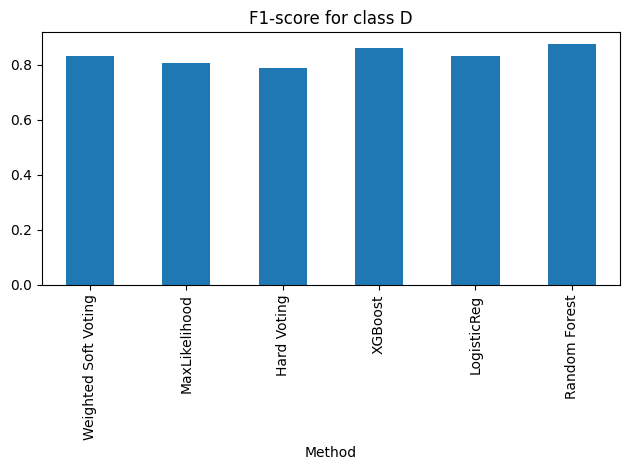

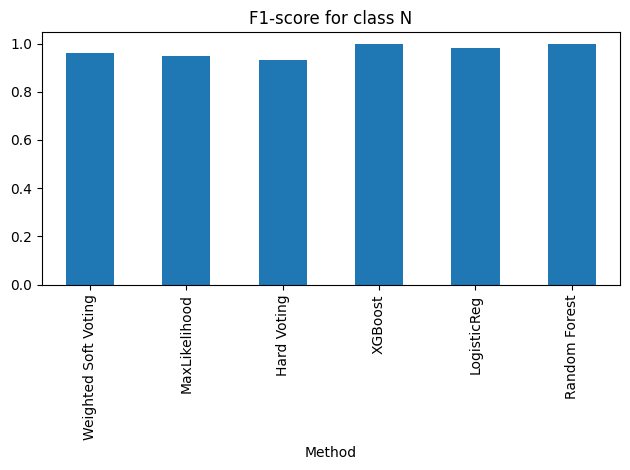

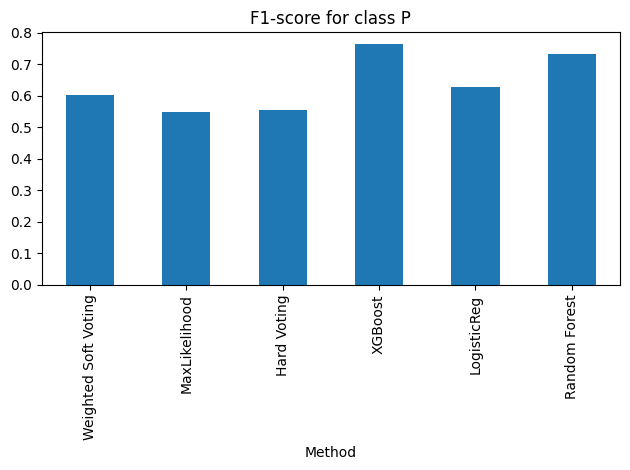

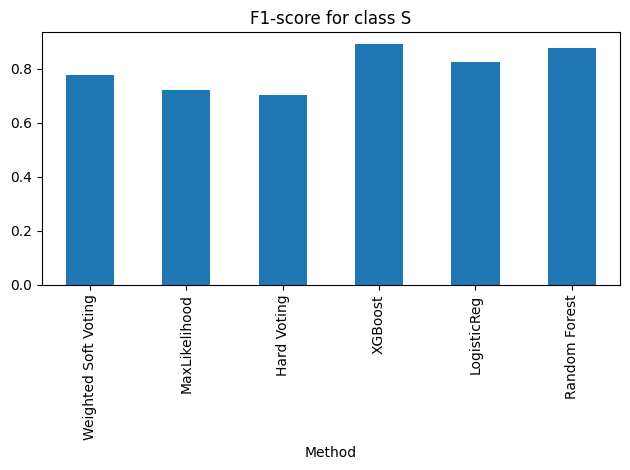

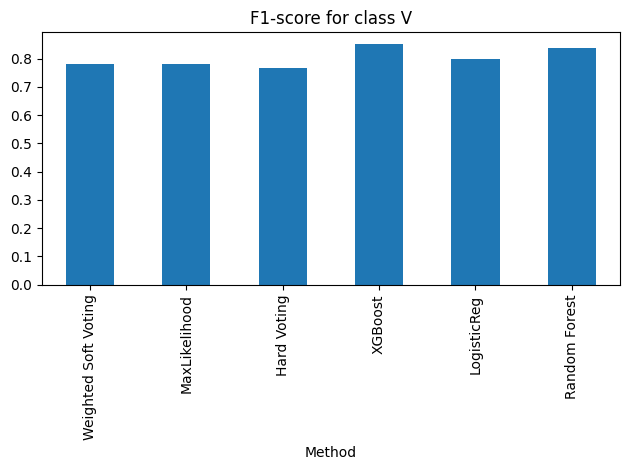

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build a DataFrame
rows = []
for method, rpt in ensemble_reports.items():
    row = {
        'Method':   method,
        'Accuracy': rpt['accuracy'],
        'Macro F1': rpt['macro avg']['f1-score']
    }
    for cls in class_names:
        row[f'{cls} F1'] = rpt[cls]['f1-score']
    rows.append(row)

df = pd.DataFrame(rows).set_index('Method')

# 2) Display the table (in Jupyter/IPython)
from IPython.display import display
display(df)

# 3) Plot overall metrics
plt.figure()
df['Accuracy'].plot.bar()
plt.title('Accuracy comparison')
plt.tight_layout()
plt.show()

plt.figure()
df['Macro F1'].plot.bar()
plt.title('Macro F1 comparison')
plt.tight_layout()
plt.show()

# 4) Plot per-class F1
for cls in class_names:
    plt.figure()
    df[f'{cls} F1'].plot.bar()
    plt.title(f'F1-score for class {cls}')
    plt.tight_layout()
    plt.show()
